In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!gsutil -m cp gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip  ./

Copying gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][593.6 MiB/593.6 MiB] 100% Done  60.4 MiB/s ETA 00:00:00           
Operation completed over 1 objects/593.6 MiB.                                    


In [ ]:
!unzip -q /content/cats_vs_dogs_dataset.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Define the custom callback function to track and plot training metrics
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        print(f"Epoch {epoch + 1}/{self.params['epochs']} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

In [ ]:
class UploadModel(tf.keras.callbacks.Callback):
    def __init__(self, num_epochs = 10):
      self.num_epochs = num_epochs

    def on_epoch_end(self, epoch, logs=None):
      if (epoch+1) % self.num_epochs == 0:
        filepath = f"/content/models/Cats_vs_Dogs_EffB0-{epoch+1:02d}.h5"
        model.save(filepath, include_optimizer=True)
        !gsutil -mq cp {filepath} gs://tibot-ml-labeling/models/cats_vs_dogs_task/shaheer/randomweight_model/model/
        print(f"{filepath} saved in bucket")

In [ ]:
train_df = "/content/dataset/train"
test_df = "/content/dataset/test"

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Data preprocessing and augmentation for testing/validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
# Define batch size
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    test_df,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_df,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 17990 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.


In [ ]:
# Create and compile the model (EfficientNetV2 B2 from random weights)
base_model = EfficientNetV2B2(weights=None, include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model (EfficientNetV2 B2 from random weights)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[CustomCallback(), UploadModel()]  # Use the custom callback for model upload
)

Epoch 1/10
563/563 [==============================] - 381s 574ms/step - loss: 0.7156 - accuracy: 0.4958 - val_loss: 0.6650 - val_accuracy: 0.7407
Epoch 2/10
563/563 [==============================] - 300s 532ms/step - loss: 0.6972 - accuracy: 0.5016 - val_loss: 0.7038 - val_accuracy: 0.2593
Epoch 3/10
563/563 [==============================] - 301s 534ms/step - loss: 0.6961 - accuracy: 0.5002 - val_loss: 0.6633 - val_accuracy: 0.7407
Epoch 4/10
563/563 [==============================] - 308s 547ms/step - loss: 0.6954 - accuracy: 0.4958 - val_loss: 0.6959 - val_accuracy: 0.2593
Epoch 5/10
563/563 [==============================] - 307s 546ms/step - loss: 0.6953 - accuracy: 0.5008 - val_loss: 0.7182 - val_accuracy: 0.2593
Epoch 6/10
563/563 [==============================] - 299s 530ms/step - loss: 0.6947 - accuracy: 0.4948 - val_loss: 0.6891 - val_accuracy: 0.7407
Epoch 7/10
563/563 [==============================] - 300s 532ms/step - loss: 0.6865 - accuracy: 0.5336 - val_loss: 12.5585 

In [ ]:
import numpy as np

# Get the class labels
class_labels = validation_generator.class_indices.keys()

# Create classification reports
y_true = validation_generator.classes
# Get the maximum probability for each class
y_pred = np.argmax(model.predict(validation_generator), axis=1)

print("Classification Report for Model (Random Weights):")
print(classification_report(y_true, y_pred, target_names=class_labels))

148/148 [==============================] - 14s 92ms/step
Classification Report for Model (Random Weights):
              precision    recall  f1-score   support

        cats       0.74      1.00      0.85      3505
        dogs       0.00      0.00      0.00      1227

    accuracy                           0.74      4732
   macro avg       0.37      0.50      0.43      4732
weighted avg       0.55      0.74      0.63      4732



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Create confusion matrices
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3505    0]
 [1227    0]]


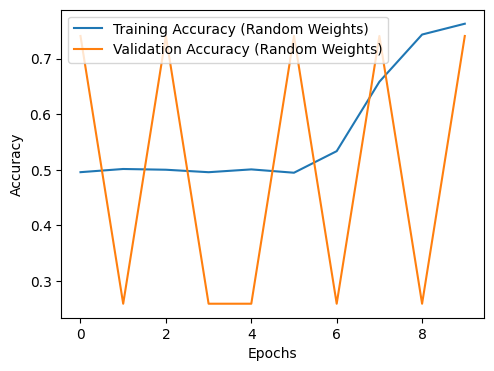

In [ ]:
# Plot training metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy (Random Weights)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Random Weights)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()